# NLP-A Topic Modeling - Lantent Dirchlet Allocation (LDA) using Gensim

## What is Topic Modeling?

Oneo of the primary applications of MLP is to automatically extract what topics people are discussing from large columes of text. Some examples of large text could be feeds from social media, customer reviews of hotels, movies, user feedbacks, news stories, e-mails of customer complaints, etc.

The statistical process of learning and extracting these topics from the huge amount of documents in an unsupervised manner is called **topic modeling**.

![Machine Learning Tree](./res/img/ml_tree.png)

It's difficult to manually read through such large volumes and compile the topics. Thus, we need an automated algorithm like LDA that can read through the text and output the topics discussed.

## Topic Modeling Use Cases

- Document categorization
- Document summarization
- Dimension reduction using **_doc words matrix_** to **_doc topic matrix_** conversion

## Our Business Problem

Suppose we never had a category of the new article with us and we had to cluster together similar documents by similar topics. LDA can solve this for us.

In [32]:
import re
import nltk
import spacy
import gensim
import nlp
import pandas as pd
import numpy as np

nltk.download('stopwords')

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style='darkgrid', palette='viridis', context='talk')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lsantos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: Deprecatio

In [33]:
df = pd.read_csv('./res/data/bbc-text.csv')
print(df.shape)
df.head()

(2225, 2)


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


There are a total of 2410 articles in the dataset that we need to divide into similar topics. The article text is written in a column named `text` and the category is indicated in the column `category`.

## Preprocessing Data

In [17]:
# remove emails, newline characters, stopwords, and perform tokenization
data = df['text'].values.tolist()

data = [re.sub(r'\S*@\S*\s?', '', i) for i in data]
data = [re.sub(r'\s+', ' ', i) for i in data]
data = [re.sub(r"\'", "", i) for i in data]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True)) # deacc=True removes accent marks from tokens using gensim.utils.deaccent

In [15]:
data_words = list(sent_to_words(data))
print(data_words[1])

['worldcom', 'boss', 'left', 'books', 'alone', 'former', 'worldcom', 'boss', 'bernie', 'ebbers', 'who', 'is', 'accused', 'of', 'overseeing', 'an', 'bn', 'bn', 'fraud', 'never', 'made', 'accounting', 'decisions', 'witness', 'has', 'told', 'jurors', 'david', 'myers', 'made', 'the', 'comments', 'under', 'questioning', 'by', 'defence', 'lawyers', 'who', 'have', 'been', 'arguing', 'that', 'mr', 'ebbers', 'was', 'not', 'responsible', 'for', 'worldcom', 'problems', 'the', 'phone', 'company', 'collapsed', 'in', 'and', 'prosecutors', 'claim', 'that', 'losses', 'were', 'hidden', 'to', 'protect', 'the', 'firm', 'shares', 'mr', 'myers', 'has', 'already', 'pleaded', 'guilty', 'to', 'fraud', 'and', 'is', 'assisting', 'prosecutors', 'on', 'monday', 'defence', 'lawyer', 'reid', 'weingarten', 'tried', 'to', 'distance', 'his', 'client', 'from', 'the', 'allegations', 'during', 'cross', 'examination', 'he', 'asked', 'mr', 'myers', 'if', 'he', 'ever', 'knew', 'mr', 'ebbers', 'make', 'an', 'accounting', 'de

In [4]:
# remove stopwords and lemmatize tokens
from nltk.corpus import stopwords
import en_core_web_sm

nlp = en_core_web_sm.load()
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):
    # storage
    texts_out = []
    # convert text to tokens and lemmatize the nouns
    for text in texts:
        doc = nlp(' '.join(text))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data_words_nostops = remove_stopwords(data_words)
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN'])

In [13]:
len(np.unique(data_lemmatized))

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


2101

## LDA Model (Latent Dirichlet Allocation)

LDA is an unsupervised Generative probabilistic machine learning technique used for extracting:
- number of topics in data (corpus)
- distribution of topics in each text (document)
- distribution of words (terms) in each topic

> **_NOTE_**: A topic is defined as a repeating pattern of co-occuring terms in a corpus.

### How LDA Works

The two main inputs to the LDA topic model are:
- the `dictionary` : unique ids for each unique word 
- the `corpus` : number of times a particular word is used in each document (Document Term Matrix)
> e.g. \
> **_corpus_** document = [(0,1), (1,2), (2,1), (3,1), (4,1), (5,3), ... (`i`,`j`)] \
> This `corpus` specifies that within `document`, a particular `word` with id `i` appears `j` number of times.


The goal of LDA is to find the optimized representation of `doc-topic matric` and `topic-term matrix`.

![LDA Workflow](./res/img/lda_workflow.png)

Inputs:
- `M` : # of documents
- `N` : # of words per document
- $\alpha$ : per-document topic distribution
- $\beta$ : concentration parameters
> High $\alpha$ means documents have greater topic variation. \
> Low $\alpha$ means documents are better represented by fewer topics. \

> High $\beta$ means topics have greater word variation. \
> Low $\beta$ means topics are better represented by fewer words.

Outputs:
- `K` : # of topics
- `document-topic` distribution
- `topic-term` distribution

Misc. Terms:
- $\Phi(k)$ : topic probability per word
- $\Theta(i)$ : topic probability per document
- $w(i,j)$ : `j` word in `i` document
- $Z(i,j)$ : topic assignment for $w(i,j)$

### How LDA Decides Topics for Document

Assuming a corpus (DTM or Document-Topic Matrix), LDA backtracks and estimates which words must have generated the topics and which topics must have generated the documents.

1. Assign random topic to each word.
2. Iterates word `w` for each document and adjusts current topic-word assignment with new assignment.
3. New topic `k` assigned to word `w` with probability `P`, which is a product of two probabilities, `P1` and `P2`.
    - `P1` is proportion of word `w` over document `d` (i.e., proportion of words `w` in document `d` that are assigned to current topic `t`).
    - `P2` is proportion of word `w` over topic `t` (i.e., proporiton of assignments to topic `t` from word `w` across all documents `d`).
4. Iterate above steps until LDA converges on stable values.

In [19]:
# create dictionary
id2word = corpora.Dictionary(data_lemmatized)
print(id2word)

# create corpus
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

Dictionary<10953 unique tokens: ['advert', 'advertising', 'bill', 'book', 'box']...>


## Create base model

In addition to the corpus and dictionary, the number of topics `k` will also be required. We can choose `k` per use case.

That aside, $\alpha$ and $\beta$ are hyperparameters that affect the sparsity of the topics. `chunk size` is the number of documents to be used in each training batch, which controls how many documents are processed at a time in the training algorithm. Increasing the `chunk size` will speed up training but may be less stable depending on you system.

`update_every` determines how often the model parameters should be updated and `passes` controls how often a particular loop is repeated over each document.

In [20]:
# baseline model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=5,
    random_state=100,
    chunksize=200,
    passes=10,
    per_word_topics=True
    )

We created 5 topics. You can view the keywords for each topic and the weights ofeach keyword below:

In [24]:
# print the keyword in the 5 topics
doc_lda = lda_model[corpus]
lda_model.print_topics()

[(0,
  '0.026*"year" + 0.022*"sale" + 0.013*"player" + 0.012*"time" + 0.011*"price" + 0.010*"growth" + 0.009*"club" + 0.009*"car" + 0.009*"side" + 0.008*"market"'),
 (1,
  '0.017*"government" + 0.013*"people" + 0.013*"party" + 0.011*"year" + 0.010*"election" + 0.009*"company" + 0.008*"labour" + 0.008*"plan" + 0.008*"country" + 0.007*"tax"'),
 (2,
  '0.024*"people" + 0.013*"phone" + 0.012*"attack" + 0.012*"technology" + 0.011*"network" + 0.011*"service" + 0.011*"computer" + 0.010*"site" + 0.010*"firm" + 0.009*"software"'),
 (3,
  '0.040*"film" + 0.019*"music" + 0.019*"year" + 0.017*"award" + 0.010*"album" + 0.010*"number" + 0.009*"cinema" + 0.009*"show" + 0.009*"dance" + 0.009*"tv"'),
 (4,
  '0.042*"game" + 0.016*"time" + 0.014*"year" + 0.013*"world" + 0.010*"prisoner" + 0.008*"sport" + 0.008*"way" + 0.008*"title" + 0.008*"woman" + 0.007*"man"')]

## Evaluation - Topic Coherence

Topic coherence measures the average similarity between top words having the highest weights in a topic (i.e., relative distance between the top words).

In [25]:
coherence_model_lda = CoherenceModel(
    model=lda_model,
    texts=data_lemmatized,
    dictionary=id2word,
    coherence='c_v'
    )

coherence_lda = coherence_model_lda.get_coherence()

print(f'Coherence Score: {coherence_lda}')

Coherence Score: 0.4266177583273783


## Model Improvement

The approach to finding the optimal number of topics is to build many LDA models with different values of a number of topics `k` and pick the one that gives the highest coherence value. Choosing a `k` that marks the end of the rapid growth of topic coherence usually offers meaningful and interpretable topics.

Picking an even higher value can sometimes provide more granular sub-topics. If you see the same keywords being repeated in multiple topics, it's probably a sign that the `k` is too large.

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics.
    
    Parameters:
    -----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    
    Returns:
    --------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            num_topics=num_topics,
            random_state=100,
            chunksize=200,
            passes=10,
            per_word_topics=True,
            id2word=id2word
        )
        
        model_list.append(model)
        
        coherencemodel = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

In [28]:
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus,
    texts=data_lemmatized,
    start=2,
    limit=8,
    step=1
)

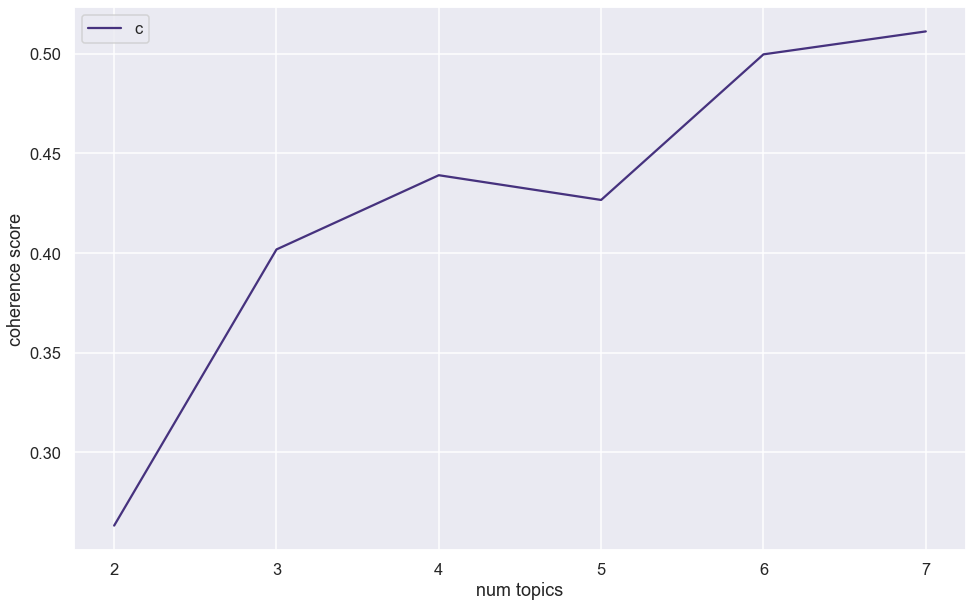

In [36]:
# graph
limit=8; start=2; step=1
x = range(start, limit, step)

fig,ax = plt.subplots(figsize=(16,10))
ax.plot(x, coherence_values)
ax.set_xlabel('num topics')
ax.set_ylabel('coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [31]:
# print the coherence scores
for m, cv in zip(x, coherence_values):
    print(f'num topics = {m} has Coherence Value of {round(cv, 4)}.')

num topics = 2 has Coherence Value of 0.2633.
num topics = 3 has Coherence Value of 0.4018.
num topics = 4 has Coherence Value of 0.439.
num topics = 5 has Coherence Value of 0.4266.
num topics = 6 has Coherence Value of 0.4996.
num topics = 7 has Coherence Value of 0.5111.


In [47]:
def compute_coherence_model(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=5,
        random_state=100,
        chunksize=200,
        passes=10,
        alpha=a,
        eta=b,
        per_word_topics=True
    )
    
    coherence_model_lda = CoherenceModel(
        model=lda_model,
        texts=data_lemmatized,
        dictionary=dictionary,
        coherence='c_v'
        )
    
    return coherence_model_lda.get_coherence()

In [48]:
import tqdm

grid = {}
grid['Validation Set'] = []

# topics range
min_topics = 2
max_topics = 7
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

In [49]:
# validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75))]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {
    'validation_set' : [],
    'topics' : [],
    'alpha' : [],
    'beta' : [],
    'coherence' : []
    }

if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # for each corpus
    for i in range(len(corpus_sets)):
        
        # for each topic
        for k in topics_range:
            
            # for each alpha value
            for a in alpha:
                
                # for each beta value
                for b in beta:
                    
                    # calculate coherence score
                    cv = compute_coherence_model(
                        corpus=corpus_sets[i],
                        dictionary=id2word,
                        k=k,
                        a=a,
                        b=b
                    )
                    
                    # save model results
                    model_results['validation_set'].append(corpus_title[i])
                    model_results['topics'].append(k)
                    model_results['alpha'].append(a)
                    model_results['beta'].append(b)
                    model_results['coherence'].append(cv)
                    
                    pbar.update(1)
    
    pd.DataFrame(model_results).to_csv('./res/data/lda_tuning_results_new.csv', index=False)
    pbar.close()

 28%|██▊       | 150/540 [19:57<51:54,  7.99s/it]


## Final LDA Model

In [ ]:
lda-

# Visualize the Topics-Keywords

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_final, corpus, id2word)